# Quafing example workflow

This notebook demonstrates the use of quafing on the basis of an example workflow analysing quesstionaire data about subaks. The answers to the individual questions are assumed to be entirely independent.


This notebook assumes that it being executed from `quafing/notebooks/`, i.e. that `quafing/quafing/` is at the same directory hierarchy level, with aa shared parent directory. Before beginning we change the working directory to this common parent directory

In [4]:
import os
os.chdir('../quafing/')
print(os.getcwd())

/Users/charlesdupont/Desktop/Thesis/code/quafing


Start by importing quafing. (If quafing is installed via a package manager the previous step can be ignored)

In [7]:
import quafing as q

### Data ingestion

Specify the file name of the questionaire data (needs to be adapted by user)


In [10]:
filepath = "../notebooks/data/omri_subak_data.xlsx"

In general for spreadsheet type files (.xlsx,.xls,.odf.,ods), quafing assumes columnar data with meta data on the columns located on the same sheet. The standard format corresponds to (all columns and row are 0-indexed):

- Data and metadata are located on sheet 0.
- Row 0 contains the column type (see below)
- Row 1 contains the number of the asociated question
- Row 2 (header row) contains the column names
- Data starts on row 3
- No rows (read 0) are skipped at the end

standard row types (denoted by single str characters) are:

    e: excluded
    g: group by this column
    c: continuous variable
    u: unordered discrete
    o: ordered discrete
    b: binary
    
It should be emphasized that the user can depart from this standard. As long as the basic format of columnar data with metadata for each column is maintained, the actual inddicees of the rows can be changed. Similarly a different row type schema can be used, albeit preferably string based. However, such alterations require additional specification in quafings functions, while the default values are configired to support the standard schema


In [12]:
rawmetadata, rawdata = q.load(filepath) # no further arguments necessary in this case

quafing's `load` function loas data into a pandas DataFrame an creates a metadata dictionary.


In [13]:
rawdata.head()

,Name of Subak,Number of farmers,Ownership,sharecrop,inherited,purchased,sold,income from sawah,harvest kg/ha,satisfaction,...,organization of collective work,reading and following written rules,fines frequency,condition of subak,subal meeting effectiveness,frequency of tehcnical problems,frequency of social problems,caste conflicts effects,class effect,"resilience, capability to overcome difficulties"
0,TAMPUAGAN HILIR,95,0.35,0.0,0,1,0,0.25,200,2,...,1,1,0.9,4,3,2,3,3,3,2
1,TAMPUAGAN HILIR,95,0.60,0.0,1,0,0,0.50,250,2,...,1,1,0.9,4,3,3,3,3,3,3
2,TAMPUAGAN HILIR,95,0.60,0.0,1,0,1,1.00,210,3,...,1,1,0.9,5,3,2,3,3,3,2
3,TAMPUAGAN HILIR,95,0.25,0.0,1,0,0,0.25,200,2,...,1,1,0.9,4,2,3,2,3,3,2
4,TAMPUAGAN HILIR,95,0.30,0.0,1,0,0,0.50,200,3,...,1,1,0.9,5,3,2,3,3,3,3


### Preproccessing

Further processing, however, requires additional selection, specification, and pre-processing of the data.`quafing` supplies a `PreProcessor class` for this purpose, which takes in the data aand metadata and exposes functionss to select, split, and prepare the data for processing   

In [14]:
prep = q.PreProcessor(rawdata, rawmetadata)

We start by selecting the columns to be analyzed. Below, we create a selection, by deselecting all columns with type 'e'. However, direct selections by type or column name, or index are also possible. 

In [15]:
prep.select_columns(cols=['e'], deselect=True)

Next, we specify which columns contain continuous an discrete data, respectively. Quafing maintains an inner represenation of this distinction, thus supporting user defined column type schemes via this method. 
The default values, however, correspond to the standard defiined above.

In [16]:
prep.set_cont_disc()

With the data columns selected and the type of data specified, the penultimate preprocessing step is definng which density estimation methods are to be used in constructing the pdfs for each variable. This, again, can be done by column type, column name, or column index.

In our example all columns contain discrete data and the answers/variables are assume to be independent. Accoordingly, for each column (selected by type) a discrete 1d pdf will be estimated. 

In [17]:
prep.set_density_method(method='Discrete1D', cols=['o','u','b'])

Finally, the data is split into groups. This is based on grouping information supplied by the user (e.g. the column of type `g` in the standard format). To avoid ambiguity or mismatches with user defined type schemes, quaafing supports selection of the column to group by by column name or index only.
Here we are grouping and spliting based on the column with index 0

In [18]:
prep.split_to_groups(0)

### A collection of multi-dimensional pdfs

Having preprocessed an split the data, we can create a collection of multi-dimensional pdfs -- one for each group. As the answers for each question are assumed to be independent the full joint multidimensional pdf factorizes and we can create a factorized multi-dimensional pddf for each group, combinig them into a collection. `quafing` provides a convenience function for this operation.


In [19]:
mdpdfcol = q.create_mdpdf_collection('factorized', prep._groups, prep._grouplabels, prep._groupcolmetadata, )

Having created the collection we can calculate the Fisher information matrix, i.e. the matrix of pairwise FI distances.
Several possible algorithmic approximations of the FI distance are supported (here we use the hellinger distance). Distances are computed for each constituent pdf of the factorized multi-dimensional pdfs, and aggregated to combined distance using their root mean square.

In [20]:
mdpdfcol.calculate_distance_matrix(method='hellinger', pwdist='rms')

Given the distance matrix it is straight forward to determine the shortest path matrix

In [21]:
mdpdfcol.calculate_shortest_path_matrix()

### Embedding

Given N questions on the questionaire, the FI distances and shortest paths lie and are defined on the N-1 dimensional hypershere, making investiagting/understanding the structure of the data difficult. To this end the collection can be embedded in a lower dimensional space usingg the previously calculated information distances.

`quafing` provides an `Embedder` class, with support for a range oof embeddingg algorithms (mds, further options under development)

In [22]:
embedder = q.get_embedder('mds', mdpdfcol)

For example the multi-dimenssional pdf collection can be embedded in 2 dimensions

In [23]:
embedding = embedder.embed(dimension=2, return_all=True)

an embeding consists of the actual embedding and a dictionary with relevant data about the settings used. It is up to the user to ensure that data/multi-dimensional pdf collection and embedding stay together

In [24]:
embedding

{'embedding': array([[-0.90019149,  1.06525927],
        [-3.15306911,  1.05423888],
        [ 5.45720043,  3.53976654],
        [-3.33779766, -0.6919272 ],
        [-2.69507127, -1.60809684],
        [-0.02600298, -0.23610709],
        [-2.58932943, -2.58022469],
        [-0.71563226, -2.62394209],
        [ 0.16268011, -2.27493602],
        [-1.18111943,  3.76508559],
        [ 0.90286344,  3.61099183],
        [ 1.55208725, -3.66736125],
        [-2.37367816,  0.12464148],
        [ 4.66255965, -1.18559948],
        [ 1.94013727,  2.17950352],
        [-1.05165742,  2.17421909],
        [ 1.57424752, -0.18744448],
        [ 2.7934475 , -1.15901996],
        [ 0.41909243,  0.94191967],
        [-1.4407664 , -2.24096678]]),
 'auxinfo': {'n_components': 2,
  'metric': True,
  'max_iter': 3000,
  'eps': 1e-09,
  'random_state': RandomState(MT19937) at 0x7F84CAC38140,
  'dissimilarity': 'precomputed',
  'n_jobs': 1,
  'dimension': 2,
  'seed': 3,
  'stress': 283.7979150970999,
  'embeddi

Specifically for the MDS embedder evaluating the stress of the embedding as a function of its dimensionality (with graphical representation) is supported  

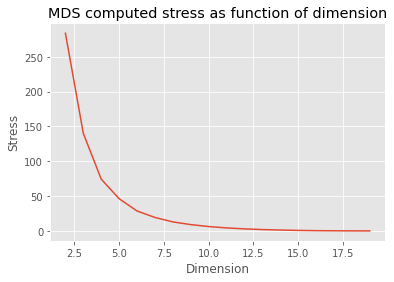

[283.7979150970999,
 139.9652085157024,
 74.37560425513949,
 46.223115959046666,
 28.631632335192393,
 19.343392173750274,
 12.9461100761546,
 9.058759981772667,
 6.2784740221057405,
 4.328332152160209,
 2.9230475717968343,
 1.9355331432101515,
 1.267175967668865,
 0.730795912531331,
 0.3731495147550691,
 0.19496856506204008,
 0.05851172722524133,
 3.425096521438625e-06]

In [25]:
embedder.eval_stress_v_dimension(plot=True)

### Visualization

Finally, for embeddings in 2 or 3 dimensions, `quafing` also provides a convenience function for visualizing the embedding, which takes the calculated embedding and the multi-dimensional pdf collection object as inputs

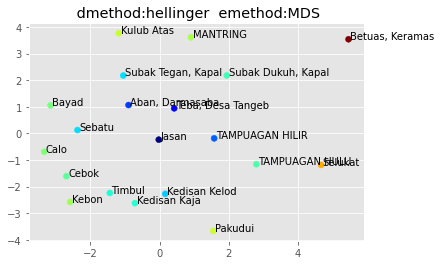

In [28]:
q.plot_embedding(embedding, mdpdfcol)

### Full capabilities

This notebook is only meant to demonstrate a questionaire analysis workflow, and DOES NOT showcase all calling options (or functionalities of `quafing`). Please consult the (inline) documentation for full details. 